<a href="https://colab.research.google.com/github/PristRawal/Machine-Learning/blob/master/02_Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating aMulti-class dataset

tensor([[-8.5550,  7.0646],
        [-6.1375, -6.5808],
        [-6.3213, -6.8041],
        [ 4.1805,  1.1233],
        [ 4.3803,  0.4700]]) tensor([3, 2, 2, 1, 1])


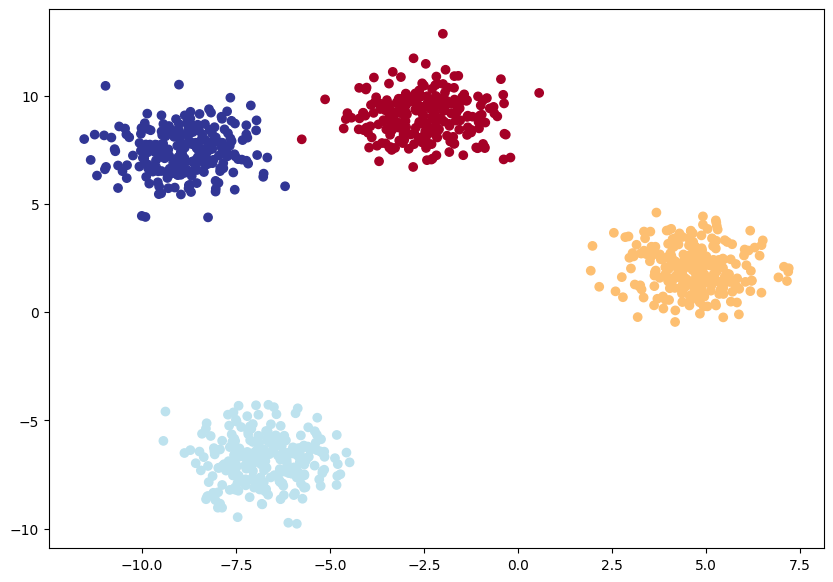

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # No. of clusters
    cluster_std=1, # Defines the std deviation(Spread) of each cluster. Higher value == Larger spread of each cluster
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #Has to be converted to LongTensor for cross-entropy loss
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# NN model

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Softmax AND Argmax

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

print(y_logits[:5])
print(y_blob_test[:5])


tensor([[-0.5011,  0.5536,  0.5259,  1.1120],
        [ 0.3667,  2.2186, -1.0166, -1.2288],
        [ 1.8386, -1.9163, -2.0483, -1.9161],
        [-0.1883, -0.0209,  0.2373,  0.8223],
        [-0.6543,  2.5674,  0.2727,  0.4366]])
tensor([1, 3, 2, 1, 0])


In [ ]:
y_pred = torch.softmax(y_logits,dim=1)
y_pred[:5]
y_pred = torch.argmax(y_pred,dim=1)
y_pred[:5]

tensor([3, 1, 0, 3, 1])

# Training and Testing

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 3.11414, Acc: 0.12% | Test Loss: 0.67931, Test Acc: 58.00%
Epoch: 10 | Loss: 0.13401, Acc: 99.88% | Test Loss: 0.11518, Test Acc: 100.00%
Epoch: 20 | Loss: 0.05598, Acc: 99.88% | Test Loss: 0.05048, Test Acc: 100.00%
Epoch: 30 | Loss: 0.03396, Acc: 99.88% | Test Loss: 0.03058, Test Acc: 100.00%
Epoch: 40 | Loss: 0.02419, Acc: 99.88% | Test Loss: 0.02150, Test Acc: 100.00%
Epoch: 50 | Loss: 0.01881, Acc: 99.88% | Test Loss: 0.01643, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01543, Acc: 99.88% | Test Loss: 0.01324, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01314, Acc: 99.88% | Test Loss: 0.01107, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01148, Acc: 99.88% | Test Loss: 0.00950, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01023, Acc: 99.88% | Test Loss: 0.00832, Test Acc: 100.00%
